<a href="https://colab.research.google.com/github/dogukartal/ML-RoadMap/blob/main/Computer%20Vision/Hugging%20Face/1_1_Vision_Transformers_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet evaluate datasets transformers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from huggingface_hub import notebook_login

from datasets import load_dataset, DatasetDict

from transformers import AutoImageProcessor, ViTForImageClassification
from transformers import Trainer, TrainingArguments

import evaluate

notebook_login()

dataset = load_dataset('pcuenq/oxford-pets')

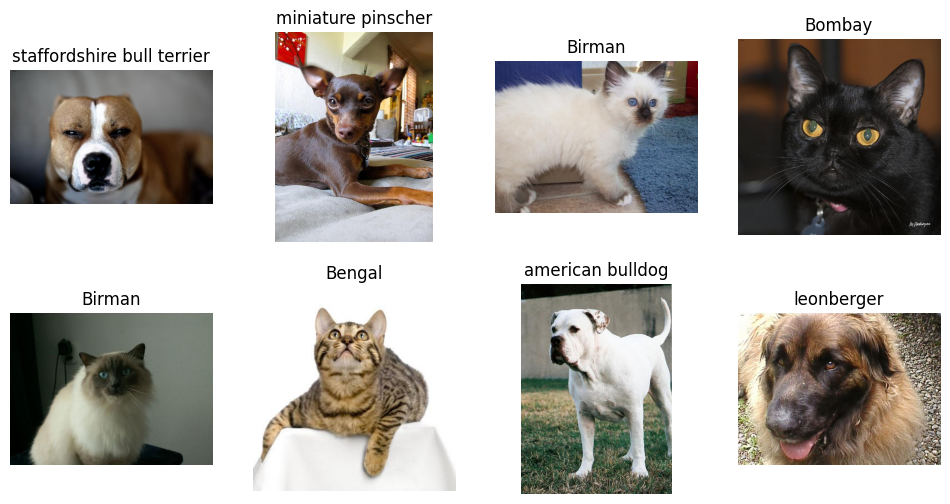

In [ ]:
from PIL import Image
import io

labels = dataset["train"].unique("label")

rows = 2
columns = 4

fig = plt.figure(figsize=(columns*3,rows*3))
samples = dataset["train"].shuffle().select(np.arange(rows*columns))

for i in range(rows*columns):
  img_bytes = samples[i]["image"]["bytes"]
  img = Image.open(io.BytesIO(img_bytes))
  label = samples[i]["label"]
  fig.add_subplot(rows,columns,i+1)
  plt.imshow(np.array(img))
  plt.title(label)
  plt.axis('off')

###Preprocessing
* Resizing
* Normalizing
* Scaling Pixel Values

In [ ]:
split_dataset = dataset["train"].train_test_split(test_size=0.2) # 80% train, 20% evaluation
eval_dataset = split_dataset["test"].train_test_split(test_size=0.5) # 50% validation, 50% test

splitted_dataset = DatasetDict({
    "train": split_dataset["train"],
    "validation": eval_dataset["train"],
    "test": eval_dataset["test"]
})

splitted_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 5912
    })
    validation: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
    test: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
})

In [ ]:
label2id = {c:idx for idx,c in enumerate(labels)}
id2label = {idx:c for idx,c in enumerate(labels)}

In [ ]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

def collate_fn(batch): # Batching our data in the correct format
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]), # (batch, channels, height, width)
        "labels": torch.tensor([x["labels"] for x in batch]) # (batch, )
    }

def transforms(batch):
    batch["image"] = [Image.open(io.BytesIO(x["bytes"])).convert("RGB") for x in batch["image"]]
    inputs = processor(batch["image"],return_tensors="pt")
    inputs["labels"]=[label2id[y] for y in batch["label"]]
    return inputs

accuracy = evaluate.load("accuracy")

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
processed_dataset = splitted_dataset.with_transform(transforms)

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True
)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([37, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Since we are not going to update the entire model, we can "freeze" all the parameters except for the new `classifier` layer by setting `requires_grad` to False for each layer's parameters.

In [ ]:
for name,p in model.named_parameters():
    if not name.startswith("classifier"):
        p.requires_grad = False

In [ ]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,827,109 | trainable_params = 28,453


### Training
---

In [ ]:
training_args = TrainingArguments(
    output_dir="./vit-base-oxford-iiit-pets",
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor
)

trainer.train()
trainer.evaluate(processed_dataset['test'])

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.146200,0.198466,0.939107
2,0.109500,0.191416,0.939107
3,0.085500,0.189004,0.940460
4,0.084100,0.185297,0.939107
5,0.086500,0.183777,0.936401


{'eval_loss': 0.1544797718524933,
 'eval_accuracy': 0.9580514208389715,
 'eval_runtime': 10.8419,
 'eval_samples_per_second': 68.162,
 'eval_steps_per_second': 8.578,
 'epoch': 5.0}

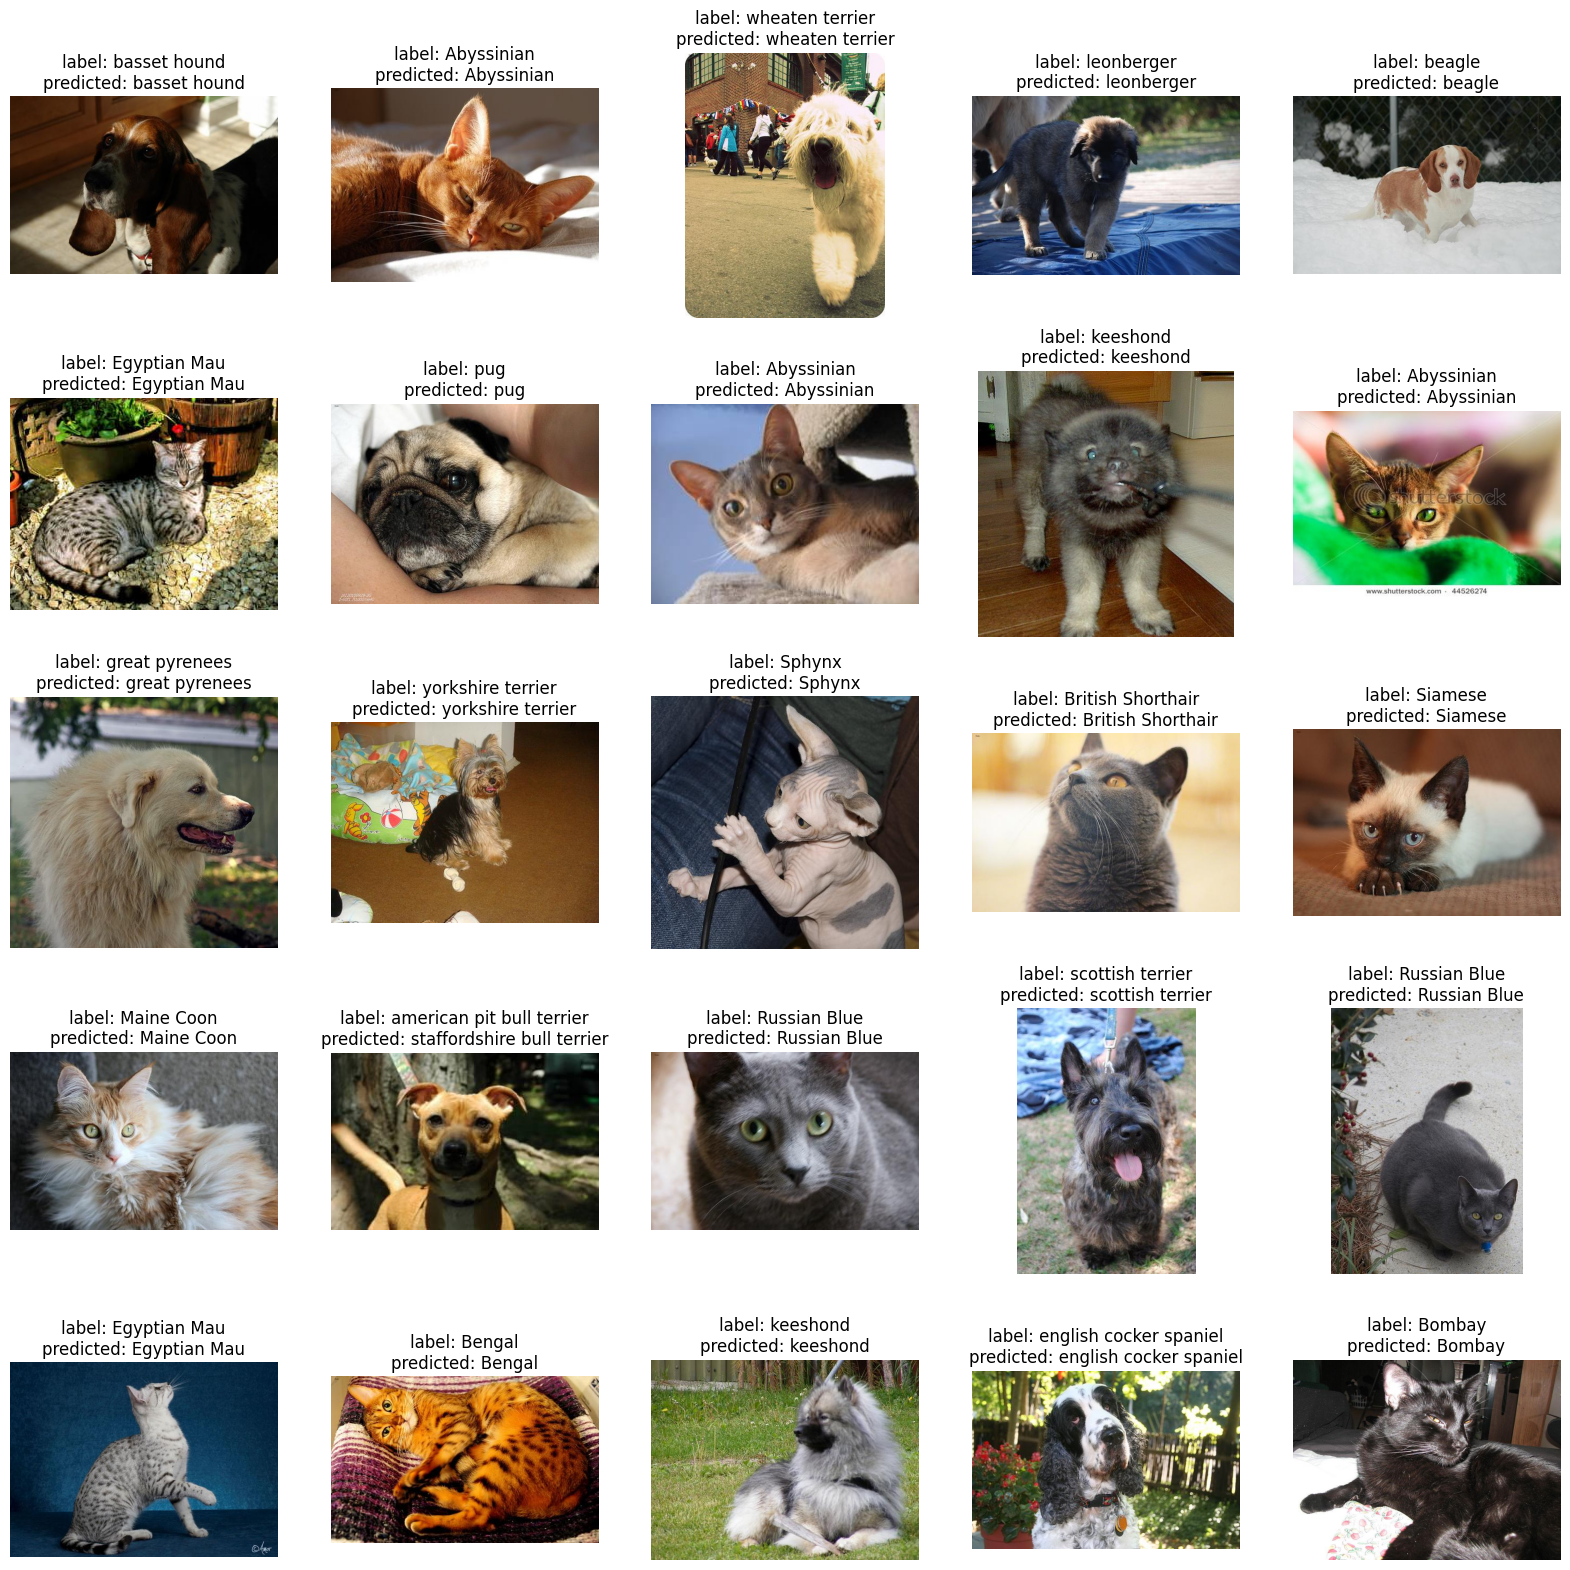

In [ ]:
def show_predictions(rows,cols):
    samples = splitted_dataset['test'].shuffle().select(np.arange(rows*cols))
    processed_samples = samples.with_transform(transforms)
    predictions = trainer.predict(processed_samples).predictions.argmax(axis=1) # predicted labels from logits
    fig = plt.figure(figsize=(cols*4,rows*4))
    for i in range(rows*cols):
        img_bytes = samples[i]["image"]["bytes"]
        img = Image.open(io.BytesIO(img_bytes))
        prediction = predictions[i]
        label = f"label: {samples[i]['label']}\npredicted: {id2label[prediction]}"
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_predictions(rows=5,cols=5)